<a href="https://colab.research.google.com/github/LorenaMueller/refine_DCG_outlines/blob/master/RF_neighbouring_pixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification to refine DCG outlines

1. Import Libraries

In [47]:
import os
import ee
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from skimage import measure
from matplotlib.patches import Patch
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.geometry import mapping
import fiona
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier
from collections import defaultdict
import random
import seaborn as sns
from collections import defaultdict
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

2. Load Data
---
In this section, the glaciers and years of interest are specified and a connection to drive is mounted to load the relevant data.

In [49]:
# Select glaciers and years
train_year = 2016  # Always using 2016 for training
train_glaciers = ['mauvoisin', 'zinal', 'zmutt', 'oberaletsch']  # Glaciers used for training
test_glacier = 'unteraar'  # Glacier to test on
test_year = [2016, 2018, 2020, 2022] # Year to test on (can be modified)
#test_year = [2016, 2016]

# ==============================================================================
# Part I
# ==============================================================================

# Mount Google Drive (for Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Paths to images stored in Google Drive
glaciers = ['zmutt', 'unteraar', 'belvedere', 'oberaletsch', 'zinal', 'mauvoisin']
years = [2016, 2018, 2020, 2022]

# Generate dynamic paths for all glaciers and years
image_paths = {}
for glacier in glaciers:
    image_paths[glacier] = {}
    for year in years:
        image_paths[glacier][year] = f"/content/drive/My Drive/GEE_Exports_input_layers_DCG/{glacier}_{year}_layers_drive.tif"

def read_raster(image_path):
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    if dataset is None:
        raise ValueError(f"Failed to open {image_path}. Check if the file exists and is readable.")
    image_array = dataset.ReadAsArray()
    return np.array(image_array)  # Ensure it's a NumPy array

# Load images directly from Google Drive
original_image_data = {}
for glacier in glaciers:
    original_image_data[glacier] = {}
    for year in years:
        original_image_data[glacier][year] = read_raster(image_paths[glacier][year])

#===============================================================================
# Assuming ground truth labels are stored separately, load them
labels_path = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zmutt_labels.tif",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/unteraar_labels.tif",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/belvedere_labels.tif",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/oberaletsch_labels.tif",
    "zinal": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zinal_labels.tif",
    "mauvoisin": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/mauvoisin_labels.tif"
}

original_label_data = {}
for key, path in labels_path.items():
    with rasterio.open(path) as src:
        original_label_data[key] = src.read(1)  # Assuming single-band label

# Paths to shapefiles stored in Google Drive
buffers_paths = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zmutt.shp",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_unteraar.shp",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_oberaletsch.shp",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_belvedere.shp",
    "zinal": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zinal.shp",
    "mauvoisin": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_mauvoisin.shp"
}

# Load shapefiles using geopandas
buffers = {key: gpd.read_file(path) for key, path in buffers_paths.items()}

# clip images with their corresponding buffer

# Function to clip a raster with its corresponding buffer
def clip_raster(raster_array, raster_path, buffer_gdf):
    with rasterio.open(raster_path) as src:
        # Reproject buffer to raster CRS
        buffer_gdf = buffer_gdf.to_crs(src.crs)
        geometries = [geom for geom in buffer_gdf.geometry]

        # Get masked raster (do not fill with 0s)
        clipped_image, clipped_transform = mask(src, geometries, crop=True, filled=False)

        # Convert masked array to np.nan outside valid area
        clipped_image = clipped_image.astype('float32')
        clipped_image = np.where(clipped_image.mask, np.nan, clipped_image.data)

        # Move bands to last axis if needed
        if clipped_image.ndim == 3:
            clipped_image = np.moveaxis(clipped_image, 0, -1)

        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[0],
            "width": clipped_image.shape[1],
            "transform": clipped_transform
        })
    return clipped_image, clipped_meta

def create_adaptive_buffer(rgi_gdf, dem_path, low_percentile=10, front_buffer=300, side_buffer=100):
    with rasterio.open(dem_path) as src:
        dem_crs = src.crs
        rgi_gdf = rgi_gdf.to_crs(dem_crs)
        geometries = [geom for geom in rgi_gdf.geometry]

        # Clip DEM to glacier polygon
        dem_clip, _ = mask(src, geometries, crop=True)
        dem_data = dem_clip[0]
        dem_data = np.where(dem_data == src.nodata, np.nan, dem_data)

        # Flatten and filter out nan
        valid_elevs = dem_data[~np.isnan(dem_data)]
        if valid_elevs.size == 0:
            print("No valid elevation data inside glacier polygon.")
            return None

        # Threshold for lowest 10%
        threshold = np.percentile(valid_elevs, low_percentile)

        # Create binary masks for lowest 10% and the rest
        low_area_mask = (dem_data <= threshold).astype(np.uint8)

        # Convert masks to vector polygons (raster to vector)
        shapes_low = list(measure.find_contours(low_area_mask, 0.5))
        low_polygons = []
        for contour in shapes_low:
            coords = [(int(x[1]), int(x[0])) for x in contour]
            poly = Polygon(coords)
            if poly.is_valid:
                low_polygons.append(poly)

        # Convert original RGI glacier polygon to shapely
        original_poly = unary_union(rgi_gdf.geometry)

        # Create two buffers
        low_area_union = unary_union(low_polygons)
        buffer_front = low_area_union.buffer(front_buffer)
        buffer_rest = original_poly.difference(low_area_union).buffer(side_buffer)

        # Combine both
        final_buffer = unary_union([buffer_front, buffer_rest])

        return gpd.GeoDataFrame(geometry=[final_buffer], crs=dem_crs)

# Dictionaries to store clipped images and labels
image_data = {}
label_data = {}

for glacier in glaciers:
  image_data[glacier] = {}  # Initialize glacier-level dictionary
  label_data[glacier], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])

for glacier in glaciers:
  for year in years:
        # Clip the image
        image_data[glacier][year], _ = clip_raster(original_image_data[glacier][year], image_paths[glacier][year], buffers[glacier])

# for glacier in glaciers:
#     label_data[glacier] = {}  # Initialize dictionary for years
#     for year in years:
#         label_data[glacier][year], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])

# Only using the specified bands for training and testing
selected_bands = ['lstNir', 'lstNir_superPixelMeans', 'edges', 'smooth', 'ndwi', 'ndsi', 'ndvi', 'slope', 'aspect', 'elevation', 'gradient', 'TPI', 'glacierInventory', 'inSAR', 'normalizedLst', 'coherence', 'VH']
bands = selected_bands

# Mapping band names to indices in the images (these should match the band order in the images)
band_indices = {
    #'lstNir': 0,
    #'ndri': 1,
    #'lstNir_superPixelMeans': 2,
    #'edges': 3,
    #'smooth': 4,
    'ndwi': 5,
    'ndsi': 6,
    'ndvi': 7,
    'slope': 8,
    #'aspect': 9,
    #'elevation': 10,
    #'gradient': 11,
    #'TPI': 12,
    #'glacierInventory': 13,
    #'inSAR': 14,
    'normalizedLst': 15,
    'coherence': 16,
    'VH': 17
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Extract-neighbours-function
---
This function is used to ectract the 4 neighbours of each pixel. These are used as additional bands in the random forest classification to provide spatial context.

In [50]:
def extract_with_neighbors(image_array, label_array, selected_bands, band_indices):
    """
    Extract pixel values and their 4 neighbors for selected bands, flatten to table format.
    Includes **all** pixels by padding the edges (mode='reflect').
    Only includes pixels with valid (non-NaN) labels.
    """
    # Pad top/bottom by 1, left/right by 1, leave band axis unchanged
    padded = np.pad(image_array, ((1, 1), (1, 1), (0, 0)), mode="reflect")

    h, w, _ = image_array.shape
    data_list = []

    # Loop over original pixel coordinates
    for y in range(h):
        for x in range(w):
            label = label_array[y, x]
            if np.isnan(label):
                continue

            feature_dict = {"label": label.item() if isinstance(label, np.ndarray) else int(label)}

            for band in selected_bands:
                if band not in band_indices:
                    continue
                idx = band_indices[band]

                # center is at padded[y+1, x+1]
                yc, xc = y + 1, x + 1
                feature_dict[f"{band}_center"] = padded[yc,   xc,   idx]
                feature_dict[f"{band}_top"]    = padded[yc-1, xc,   idx]
                feature_dict[f"{band}_bottom"] = padded[yc+1, xc,   idx]
                feature_dict[f"{band}_left"]   = padded[yc,   xc-1, idx]
                feature_dict[f"{band}_right"]  = padded[yc,   xc+1, idx]

            data_list.append(feature_dict)

    return pd.DataFrame(data_list)


4. Apply Random Forest classifier
---
In this section, the training and testing data is prepared and the Random Forest classifier (RF) is applied. The RF loops over 20 different band combinations that consist of the 35 input layers (7 base layers x 5 pixels). The classification is done for each of the test years and the results are stored for further analysis and visualisation.

In [51]:
# Prepare training and testing data
# Define bands and suffixes
base_bands = ['ndwi', 'ndsi', 'ndvi', 'slope', 'normalizedLst', 'coherence', 'VH']
suffixes = ['center', 'top', 'bottom', 'left', 'right']

# Generate selected band names (flattened list)
selected_bands_rf = [f"{band}_{suffix}" for band in base_bands for suffix in suffixes]

X_train_dfs = []
for glacier in train_glaciers:
    image = image_data[glacier][train_year]
    label = label_data[glacier]
    df = extract_with_neighbors(image, label, base_bands, band_indices)  # No need to pass band_indices
    df = df[selected_bands_rf + ["label"]]

    X_train_dfs.append(df)

train_df = pd.concat(X_train_dfs, ignore_index=True)
X_train = train_df.drop(columns="label").values
y_train = train_df["label"].values

# initialize storage containers
ensemble_results = {}
smoothed_images = {}
smoothed_images_flat = {}
reports_by_year = {}
mdi_importances_all = {}
perm_importances_all = {}
accuracies_all = {}


# training data (fixed year)
# Stratified sampling to reduce size (if needed)
sss = StratifiedShuffleSplit(n_splits=1, test_size=2, random_state=42)
for train_idx, _ in sss.split(X_train, y_train):
    X_tmp, y_tmp = X_train[train_idx], y_train[train_idx]

# Convert labels to int if not already
y_tmp = y_tmp.astype(int)

# Oversampling
X_0 = X_tmp[y_tmp == 0]
X_1 = X_tmp[y_tmp == 1]

X_1_up, y_1_up = resample(X_1, y_tmp[y_tmp == 1], replace=True, n_samples=len(X_0), random_state=42)

X_train_balanced = np.vstack((X_0, X_1_up))
y_train_balanced = np.hstack((np.zeros(len(X_0)), np.ones(len(X_0))))

# Check the class distribution in the training set before oversampling
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Similarly for the balanced training data
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
class_distribution_balanced = dict(zip(unique_balanced, counts_balanced))

# print("Class distribution in the training data (before oversampling):", class_distribution)
# print("Class distribution in the balanced training data (after oversampling):", class_distribution_balanced)
# print("Test set class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

random.seed(42)

base_bands = ['ndwi', 'ndsi', 'ndvi', 'slope', 'normalizedLst', 'coherence', 'VH']
suffixes = ['center', 'top', 'bottom', 'left', 'right']
n_combinations = 20
bands_per_combo_range = (5, 7)  # number of base bands per combination

# Track how many times each base band is used
band_usage_count = defaultdict(int)
band_combinations = []

for _ in range(n_combinations):
    # Prefer bands that have been used the least
    sorted_bands = sorted(base_bands, key=lambda b: band_usage_count[b])
    num_bands = random.randint(*bands_per_combo_range)

    selected_bands = sorted_bands[:num_bands]
    for band in selected_bands:
        band_usage_count[band] += 1

    full_band_set = [f"{band}_{suffix}" for band in selected_bands for suffix in suffixes]
    band_combinations.append(full_band_set)

# Optional: Check usage balance
# print("Band usage frequency:")
# for band in base_bands:
#     print(f"{band}: {band_usage_count[band]}")

# Extract the actual list of bands from the first (and only) combination
bands_flat = band_combinations[0]
band_indices_new = {name: idx for idx, name in enumerate(bands_flat)}

######################### TEST LOOP ############################################
for year in test_year:
   #print(f"\n=== Processing year: {year} ===")

    # === (1) Generate X_test and y_test with neighbor features ===
    image = image_data[test_glacier][year]
    label = label_data[test_glacier]
    test_df = extract_with_neighbors(image, label, base_bands, band_indices)

    X_test = test_df.drop(columns="label").values
    y_test = test_df["label"].values

    # Initialize an array to store classification results
    ensemble_result = np.zeros_like(label_data[test_glacier], dtype=int)
    #ensemble_result = np.zeros(mask.shape, dtype=int)
    #ensemble_results[year] = ensemble_result.copy()

# ==============================================================================
# Part II
# ==============================================================================

    # Storage
    mdi_importance_dict = defaultdict(list)
    perm_importance_records = []
    accuracies = []

    label_mask = (~np.isnan(label_data[test_glacier])).squeeze()
    ensemble_result = np.zeros(label_mask.shape, dtype=int)

    for bands in band_combinations:
        #print(f"Processing bands: {bands}")

        band_indices_selected = [
            band_indices_new[b] for b in bands if band_indices_new[b] < X_train_balanced.shape[1]
        ]

        if not band_indices_selected:
            print(f"Skipping bands {bands} as none were valid.")
            continue

        X_train_selected = X_train_balanced[:, band_indices_selected]
        X_test_selected = X_test[:, band_indices_selected]

        # clf = RandomForestClassifier(n_estimators=50, random_state=42, max_samples=6000)
        clf = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, eval_metric='logloss', random_state=42)

        clf.fit(X_train_selected, y_train_balanced)

        y_pred_full = clf.predict(X_test_selected).ravel()
        # print('y_pred_full', y_pred_full)
        accuracy = accuracy_score(y_test, y_pred_full)
        accuracies.append(accuracy)

        # 1. Create a flat ensemble array (same as before)
        #ensemble_result_flat = ensemble_result.flatten()

        # 2. Create the valid mask (where label_mask is non-zero)
        label_mask_flat = label_mask.flatten()
        valid_mask = label_mask_flat != 0  # Adjust the condition if necessary

        # 3. Make sure the shapes match between valid_mask and y_pred_full
        assert np.sum(valid_mask) == y_pred_full.shape[0], "Number of valid positions doesn't match number of predictions."

        # 4. Only update the valid positions in ensemble_result_flat with y_pred_full
        #ensemble_result_flat[valid_mask] += y_pred_full.astype(int)

        # 5. Reshape back to 2D
        #ensemble_result = ensemble_result_flat.reshape(label_mask.shape)

        assert y_pred_full.shape[0] == np.sum(label_mask_flat)
        ensemble_result[label_mask] += y_pred_full.astype(int)
        # At the end of the loop, after all band combinations are processed
        ensemble_results[year] = ensemble_result.copy()

        # MDI Importances (Mean Decrease in Impurity)
        for band, importance in zip(bands, clf.feature_importances_):
            mdi_importance_dict[band].append(importance)

        # Permutation Importances (Test Set)
        perm_result = permutation_importance(
            clf, X_test_selected, y_test, n_repeats=10, random_state=42, n_jobs=2
        )

        for i, band in enumerate(bands):
            for score in perm_result.importances[i]:
                perm_importance_records.append({
                    "Band": band,
                    "Permutation Importance": score
                })

        # Store MDI importance per band, aggregated (e.g., mean per band)
        mdi_importances_all[year] = {
            band: np.mean(importances) for band, importances in mdi_importance_dict.items()
        }

        # Store raw permutation importance records as a list of dicts (or later as a DataFrame)
        perm_importances_all[year] = perm_importance_records.copy()

        # Store mean accuracy across all band combinations
        accuracies_all[year] = np.mean(accuracies)


5. Visualize Permutation Importance
---
In this section, the permutation importance is visualized in boxplots. The importance is visualized per year and for each of the 7 base layers.

<Figure size 1000x600 with 0 Axes>

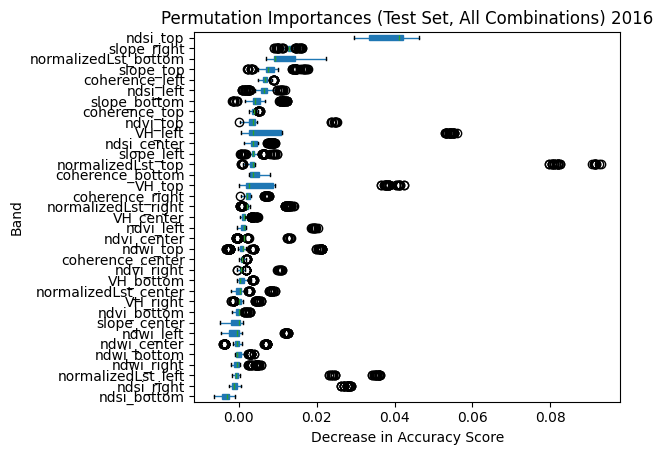

<ipython-input-52-94b6b18a61a1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


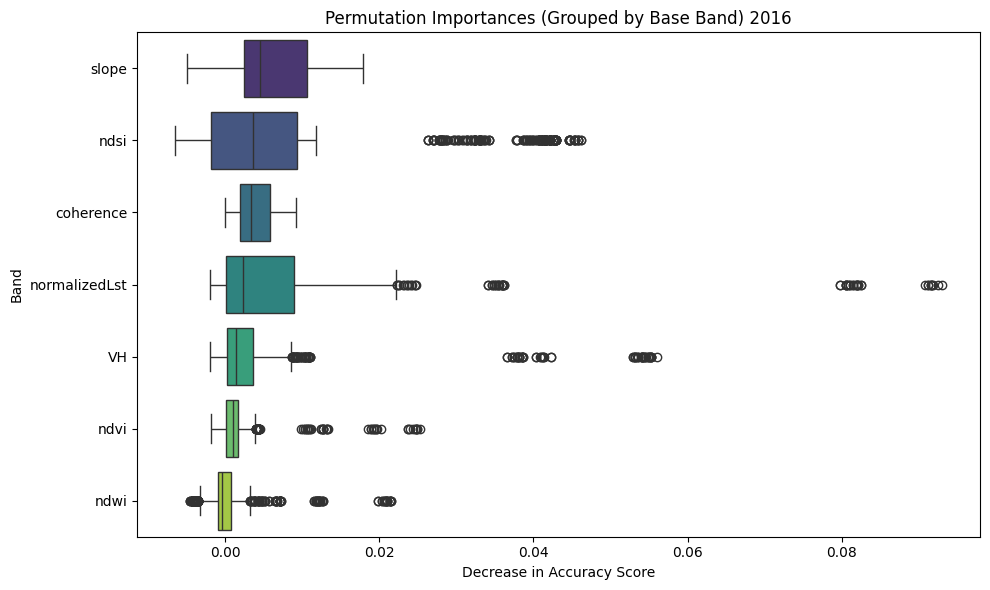

<Figure size 1000x600 with 0 Axes>

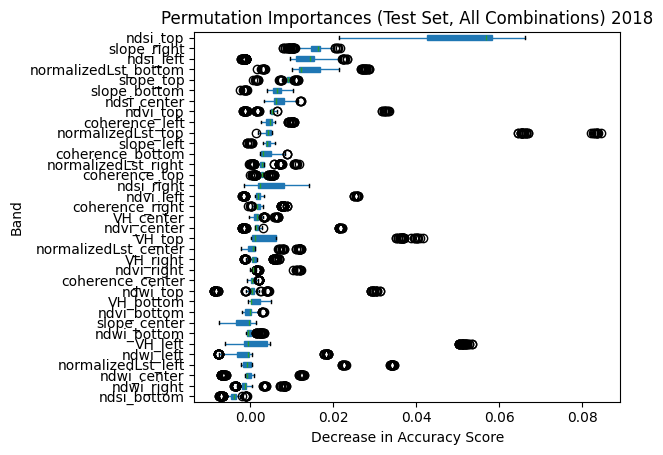

<ipython-input-52-94b6b18a61a1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


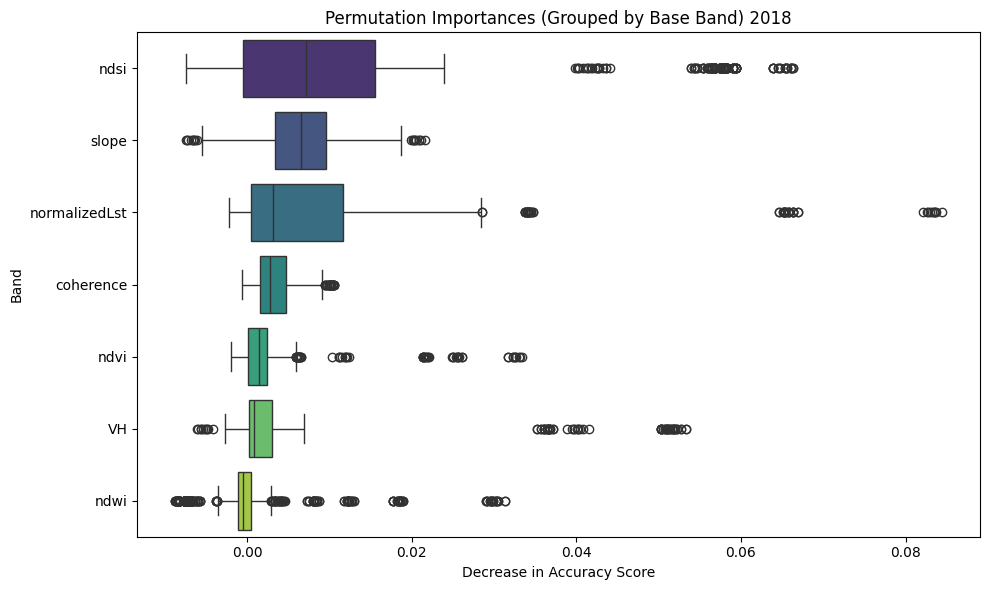

<Figure size 1000x600 with 0 Axes>

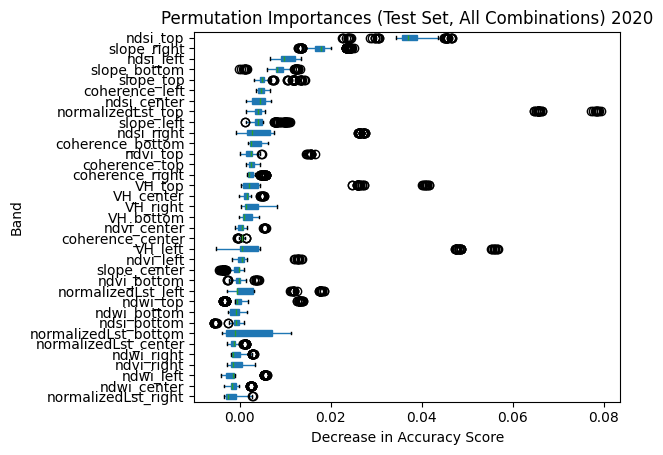

<ipython-input-52-94b6b18a61a1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


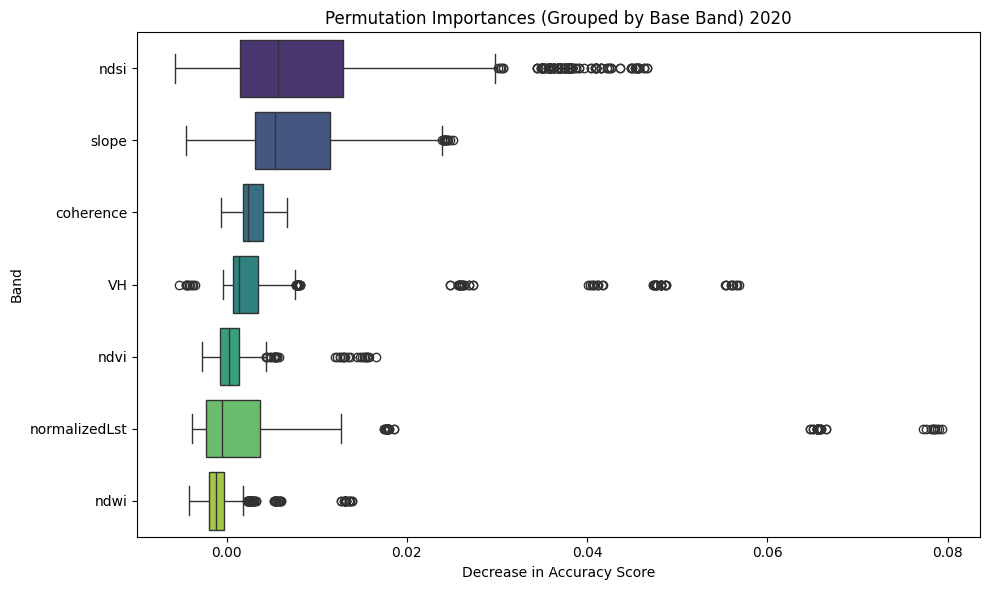

<Figure size 1000x600 with 0 Axes>

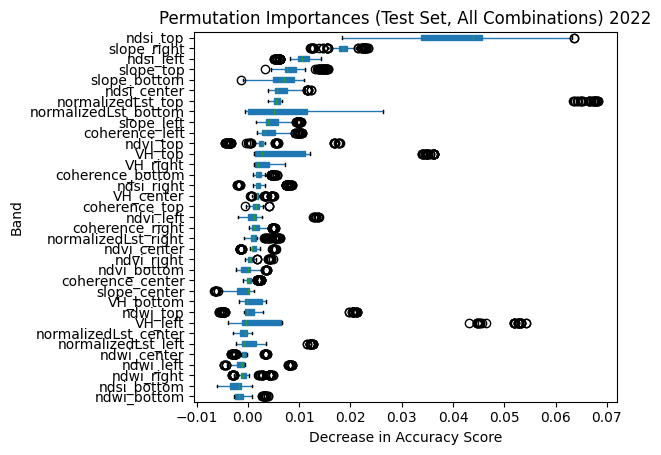

<ipython-input-52-94b6b18a61a1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


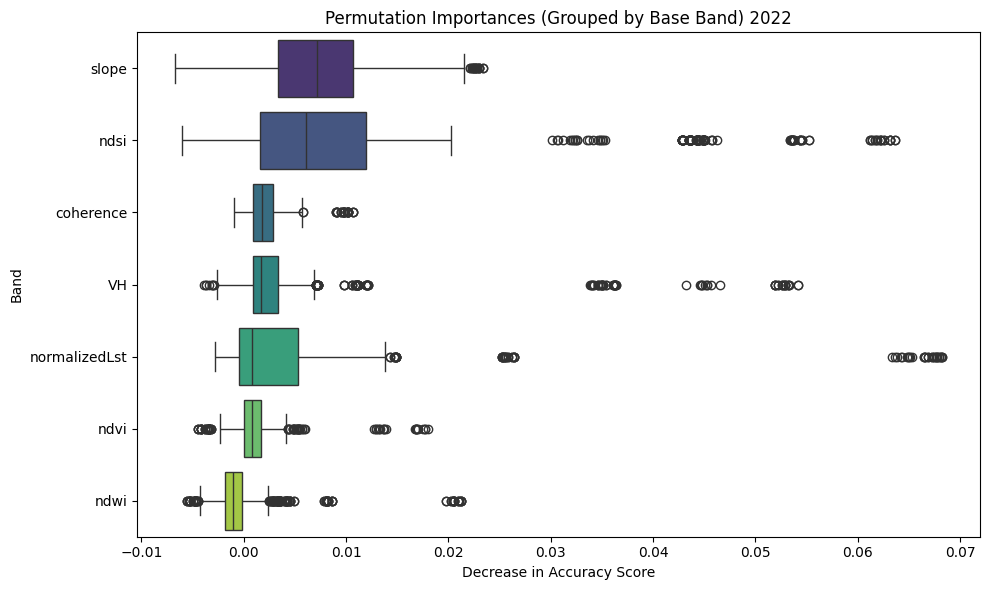

In [52]:
# -----------------------------
# Permutation Importance Boxplot
# -----------------------------
for year in test_year:

    perm_df = pd.DataFrame(perm_importances_all[year])

    import seaborn as sns  # Optional, prettier plots
    import matplotlib.pyplot as plt

    # Convert Band to categorical with sorted order
    ordered_bands = (
        perm_df.groupby("Band")["Permutation Importance"]
        .median()
        .sort_values()
        .index
    )
    perm_df["Band"] = pd.Categorical(perm_df["Band"], categories=ordered_bands, ordered=True)

    # Plot
    plt.figure(figsize=(10, 6))
    perm_df.boxplot(
        column="Permutation Importance",
        by="Band",
        vert=False,
        grid=False,
        patch_artist=True
    )
    plt.title(f"Permutation Importances (Test Set, All Combinations) {year}")
    plt.suptitle("")
    plt.xlabel("Decrease in Accuracy Score")
    plt.tight_layout()
    plt.show()

    # Extract base band name (e.g., 'ndvi' from 'ndvi_top', 'ndvi_center' etc.)
    perm_df["BaseBand"] = perm_df["Band"].apply(lambda x: "_".join(x.split("_")[:-1]))

    # Group by BaseBand, collecting all permutation scores for each variation
    grouped_df = perm_df.groupby("BaseBand")["Permutation Importance"].apply(list).reset_index()

    # Explode the list to get one value per row (for boxplotting)
    exploded_df = grouped_df.explode("Permutation Importance")

    # Sort base bands by median importance
    ordered_basebands = (
        exploded_df.groupby("BaseBand")["Permutation Importance"]
        .median()
        .sort_values(ascending=False)
        .index
    )
    exploded_df["BaseBand"] = pd.Categorical(exploded_df["BaseBand"], categories=ordered_basebands, ordered=True)

    # Plot grouped boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="Permutation Importance",
        y="BaseBand",
        data=exploded_df,
        orient="h",
        palette="viridis"
    )

    plt.title(f"Permutation Importances (Grouped by Base Band) {year}")
    plt.xlabel("Decrease in Accuracy Score")
    plt.ylabel("Band")
    plt.tight_layout()
    plt.show()

5. Thresholding, statistical evaluation and visualisation
---
This section calculates and applies a threshold to the summarized classification results. A statistical comparison to the SGI2016 evaluates precision, recall, f1-score and accuracy (only meaningful for 2016). The classification sum image and the final binary classifiction are visualized.

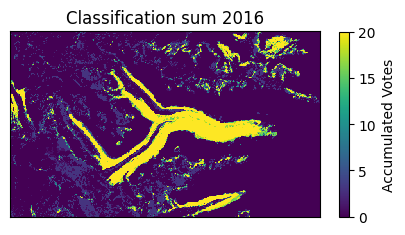

threshold otsu 9
threshold percentile 6.0
thresholds of ght [np.int64(1), np.int64(9), np.int64(16)]


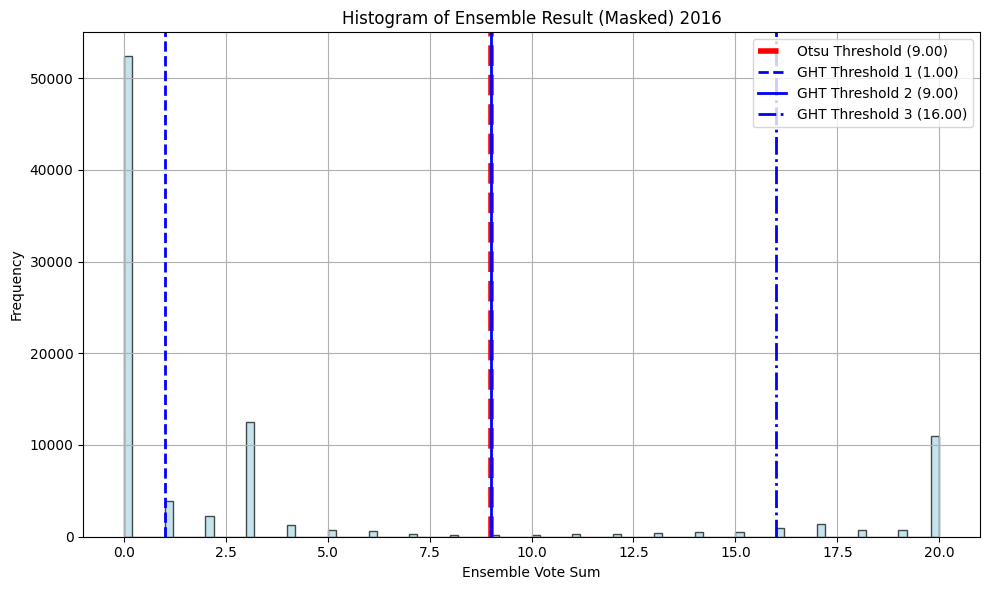

threshold used 9


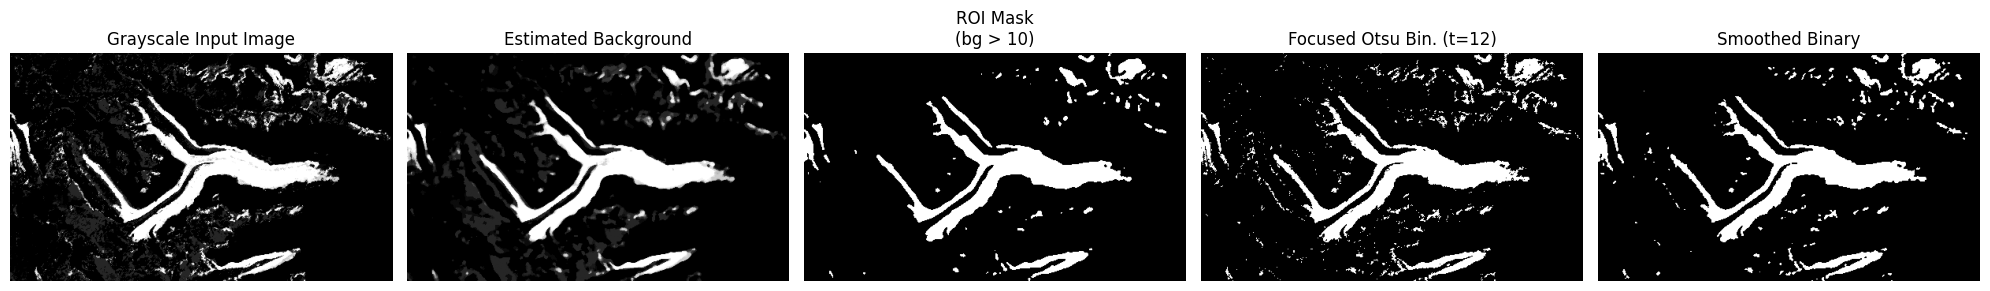

Final Accuracy (after thresholding and smoothing) 2016: 0.9319
Classification Report for final result 2016:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96     77845
         1.0       0.73      0.86      0.79     13503

    accuracy                           0.93     91348
   macro avg       0.85      0.90      0.87     91348
weighted avg       0.94      0.93      0.93     91348



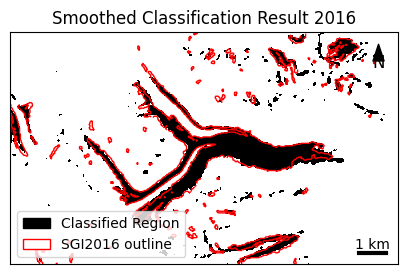


==== Summary for Year: 2016 ====
Accuracy: 0.9319
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96     77845
         1.0       0.73      0.86      0.79     13503

    accuracy                           0.93     91348
   macro avg       0.85      0.90      0.87     91348
weighted avg       0.94      0.93      0.93     91348



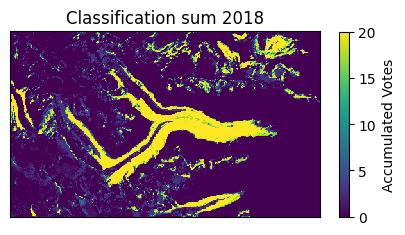

threshold otsu 9
threshold percentile 14.0
thresholds of ght [np.int64(1), np.int64(9), np.int64(16)]


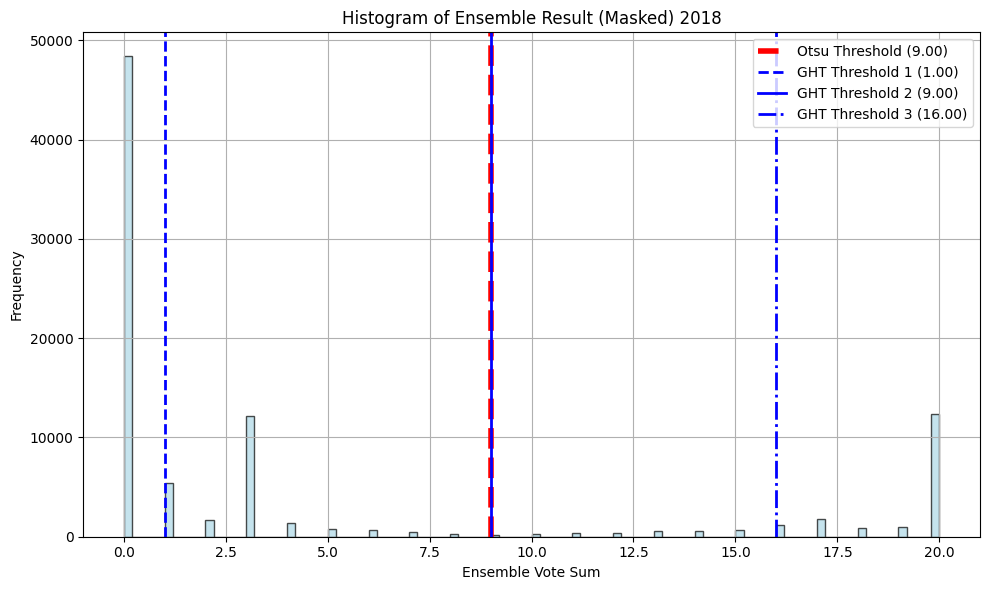

threshold used 9


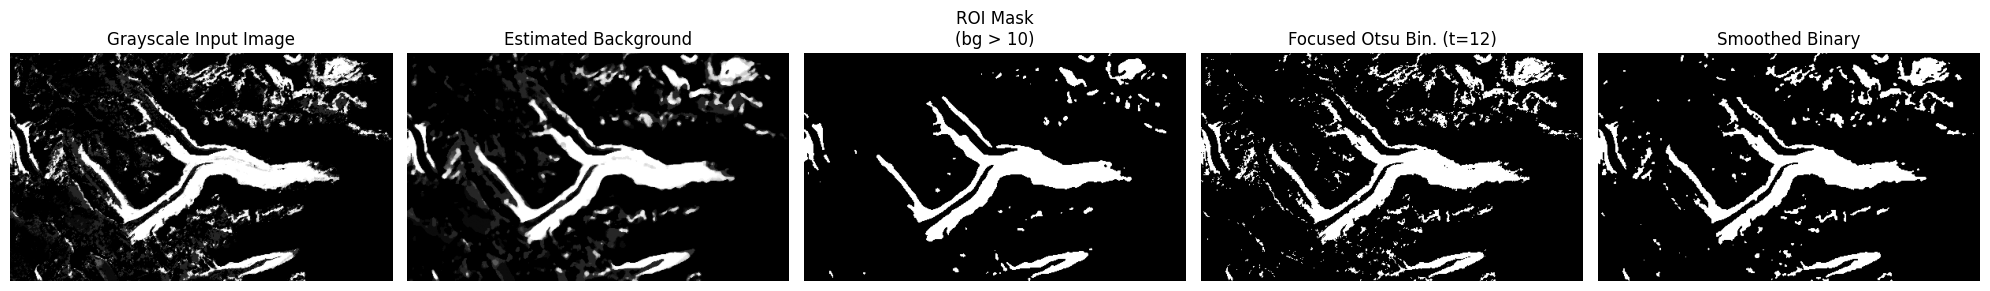

Final Accuracy (after thresholding and smoothing) 2018: 0.9055
Classification Report for final result 2018:
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     77845
         1.0       0.63      0.88      0.73     13503

    accuracy                           0.91     91348
   macro avg       0.80      0.89      0.84     91348
weighted avg       0.93      0.91      0.91     91348



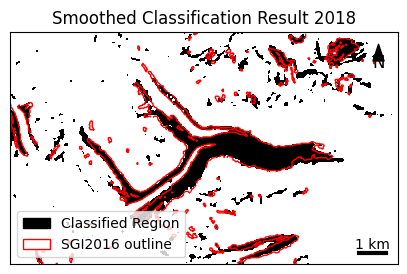


==== Summary for Year: 2018 ====
Accuracy: 0.9055
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     77845
         1.0       0.63      0.88      0.73     13503

    accuracy                           0.91     91348
   macro avg       0.80      0.89      0.84     91348
weighted avg       0.93      0.91      0.91     91348



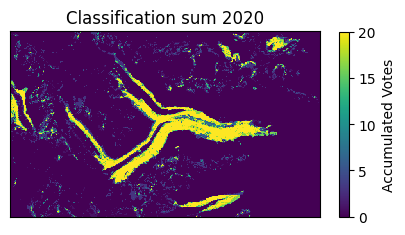

threshold otsu 9
threshold percentile 3.0
thresholds of ght [np.int64(1), np.int64(9), np.int64(16)]


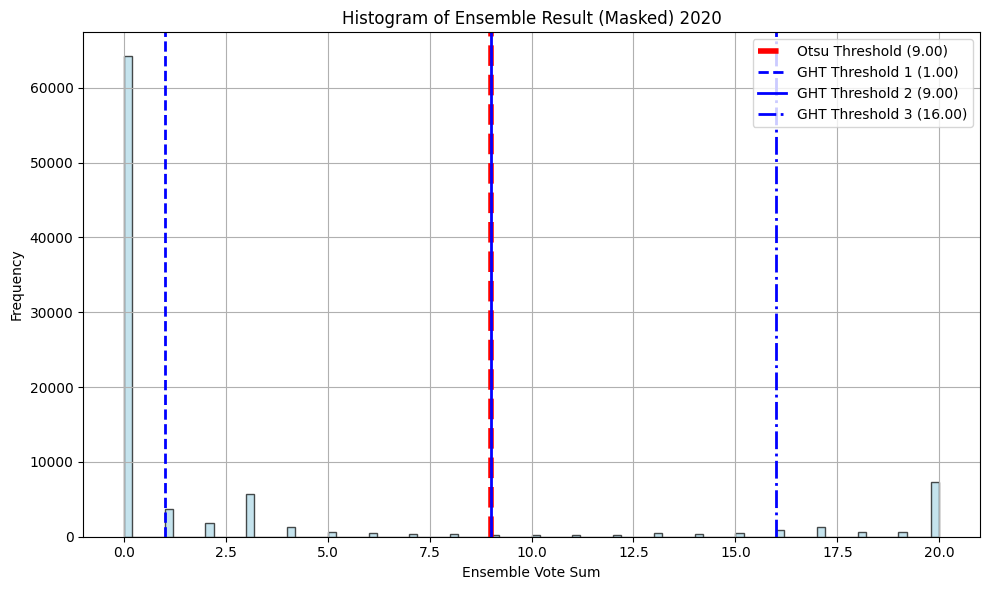

threshold used 9


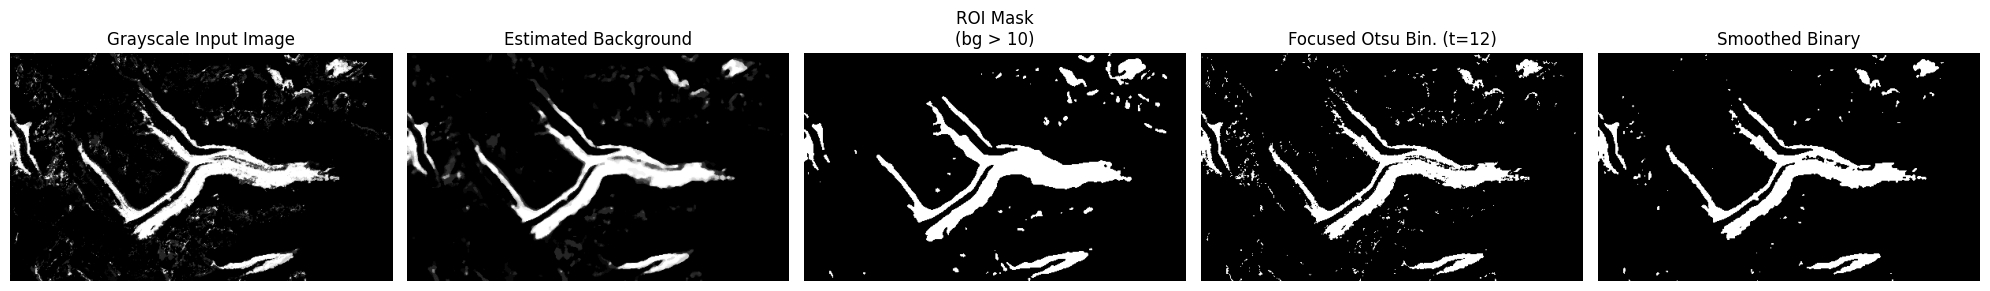

Final Accuracy (after thresholding and smoothing) 2020: 0.9310
Classification Report for final result 2020:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     77845
         1.0       0.80      0.71      0.75     13503

    accuracy                           0.93     91348
   macro avg       0.88      0.84      0.86     91348
weighted avg       0.93      0.93      0.93     91348



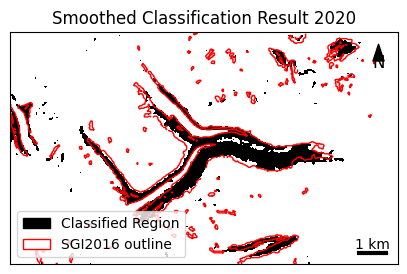


==== Summary for Year: 2020 ====
Accuracy: 0.9310
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     77845
         1.0       0.80      0.71      0.75     13503

    accuracy                           0.93     91348
   macro avg       0.88      0.84      0.86     91348
weighted avg       0.93      0.93      0.93     91348



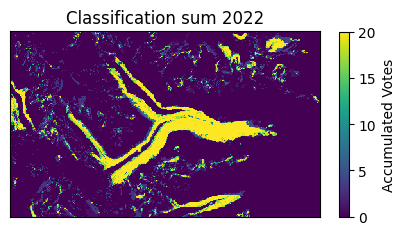

threshold otsu 9
threshold percentile 5.0
thresholds of ght [np.int64(1), np.int64(9), np.int64(16)]


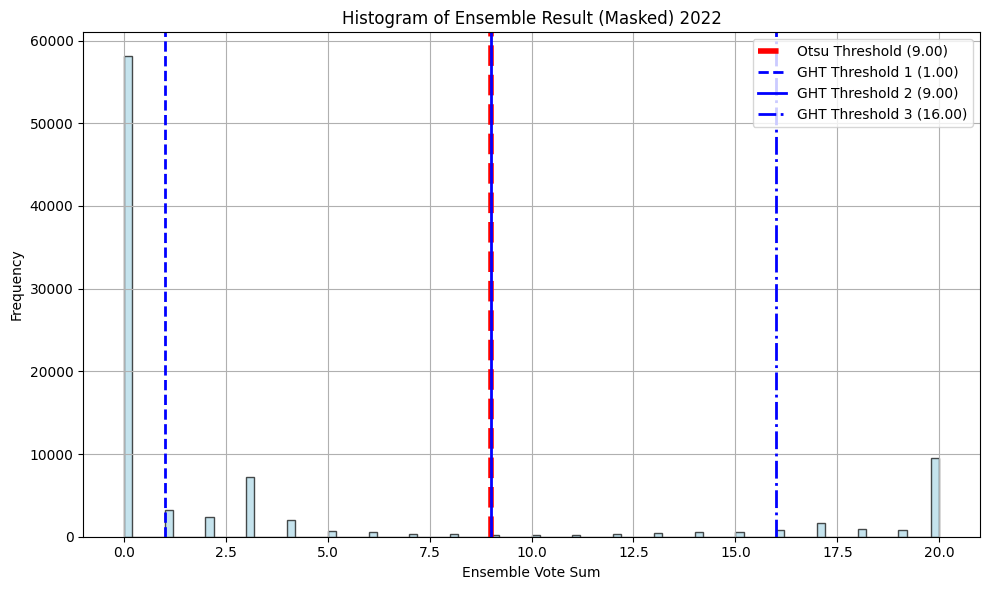

threshold used 9


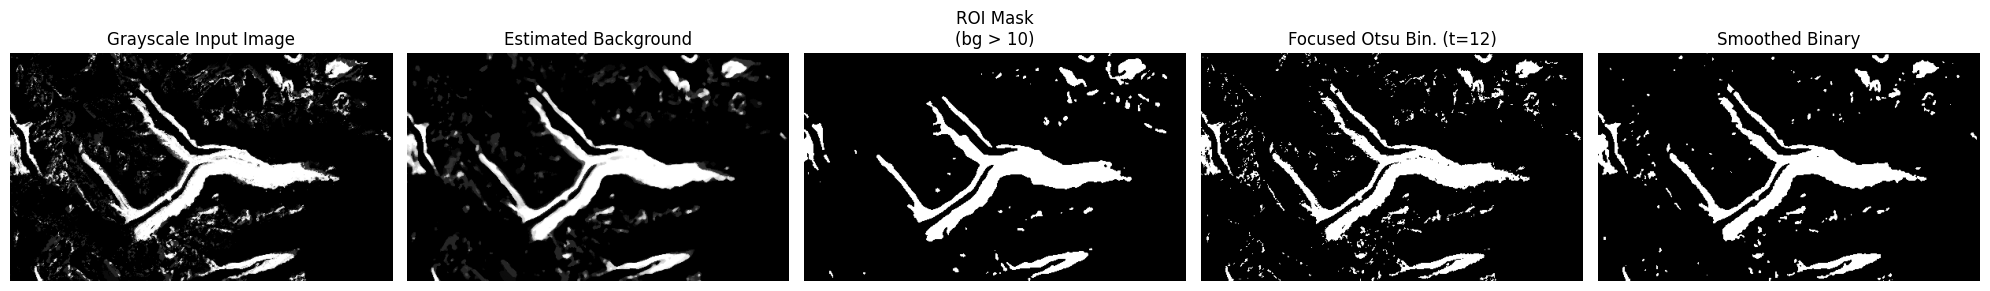

Final Accuracy (after thresholding and smoothing) 2022: 0.9216
Classification Report for final result 2022:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     77845
         1.0       0.71      0.79      0.75     13503

    accuracy                           0.92     91348
   macro avg       0.84      0.87      0.85     91348
weighted avg       0.93      0.92      0.92     91348



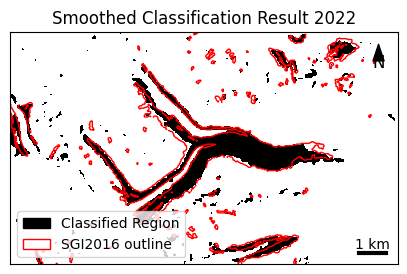


==== Summary for Year: 2022 ====
Accuracy: 0.9216
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     77845
         1.0       0.71      0.79      0.75     13503

    accuracy                           0.92     91348
   macro avg       0.84      0.87      0.85     91348
weighted avg       0.93      0.92      0.92     91348



In [57]:
from pickle import FALSE
# ==============================================================================
# Part III
# ==============================================================================
for year in test_year:
  # Plot Intermediate Classification Result (before thresholding)
  ensemble_result = ensemble_results[year]
  fig, ax = plt.subplots(figsize=(5, 4))
  im = ax.imshow(ensemble_result, interpolation='nearest', cmap="viridis")  # Using 'viridis' for better visualization

  # Remove axis labels and ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # Add colorbar to show accumulated votes
  cbar = plt.colorbar(im, ax=ax, shrink=0.6)
  cbar.set_label("Accumulated Votes")

  # Correcting label_data shape by squeezing out any extra dimensions
  label_2d = label_data[test_glacier].squeeze()

  # # Overlay ground truth labels as contours
  # contours = measure.find_contours(label_2d, level=0.5)
  # for contour in contours:
  #     ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red", label="SGI2016 Outline")
  # # Add Legend
  # legend_elements = [
  #     Patch(facecolor="white", edgecolor="red", label="SGI2016 outline")
  # ]
  # ax.legend(handles=legend_elements, loc="lower left", fontsize=10)

  plt.title(f"Classification sum {year}")
  plt.show()

  # Compute otsu threshold
  ensemble_result_masked = ensemble_result[label_mask]

  from skimage.filters import threshold_otsu
  threshold_otsuMethod = threshold_otsu(ensemble_result_masked)
  print('threshold otsu', threshold_otsuMethod)

  # Compute threshold (90th percentile - 1)
  threshold_percentile = np.percentile(ensemble_result_masked, 80)
  print('threshold percentile', threshold_percentile)



  #################### Alternatives for thresholding #########################

  from skimage.filters import threshold_otsu
  from skimage.filters.rank import mean
  from skimage.morphology import disk
  from skimage.util import img_as_ubyte
  from skimage import exposure

  def recursive_otsu(data, depth):
    if depth == 0 or len(data) == 0:
        return []
    t = threshold_otsu(data)
    left = data[data < t]
    right = data[data >= t]
    return recursive_otsu(left, depth-1) + [t] + recursive_otsu(right, depth-1)

  # Flatten masked ensemble results
  flattened = ensemble_result[label_mask].ravel()
  thresholds = recursive_otsu(flattened, depth=2)
  print('thresholds of ght', thresholds)

  # Histogram
  plt.figure(figsize=(10, 6))
  plt.hist(ensemble_result_masked, bins=100, color='lightblue', edgecolor='black', alpha=0.7)
  plt.title(f'Histogram of Ensemble Result (Masked) {year}')
  plt.xlabel('Ensemble Vote Sum')
  plt.ylabel('Frequency')

  # Plot Otsu threshold
  plt.axvline(threshold_otsuMethod, color='red', linestyle='--', linewidth=4, label=f'Otsu Threshold ({threshold_otsuMethod:.2f})')

  # # Plot percentiles
  # percentiles = [50, 60, 70, 80, 90]
  # colors = ['orange', 'gold', 'yellow', 'greenyellow', 'limegreen']

  # for perc, color, value in zip(percentiles, colors, threshold_percentile):
  #     plt.axvline(value, color=color, linestyle='-', linewidth=2, label=f'{perc}th Percentile ({value:.2f})')

  # Plot GHT thresholds
  linestyles = ['--', '-', '-.']  # or define as many as needed
  color_ght = 'blue'

  for i, value in enumerate(thresholds):
      style = linestyles[i % len(linestyles)]  # cycle if fewer styles than thresholds
      plt.axvline(value, color=color_ght, linestyle=style, linewidth=2, label=f'GHT Threshold {i+1} ({value:.2f})')

  plt.legend(loc='upper right')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  threshold = threshold_otsuMethod +6
  #print('thr used in classification', threshold)

  # Choose the best one empirically or take the median
  best_thresh = thresholds[-1]#np.median(thresholds)
  #print('thr used for classification (GHT)', best_thresh)
  # binary_classification = (ensemble_result >= best_thresh).astype(int)

  ############################################################################

  # GHT study (text-)image binarization
  import numpy as np
  import cv2
  from skimage.filters import threshold_otsu
  from scipy.ndimage import median_filter

  # Step 1: Background Estimation
  def estimate_background(image, window_size):
    background = median_filter(image, size=window_size)
    return background


  def focused_otsu(image, background, bg_thresh):
    # Apply mask on areas with strong background presence
    roi_mask = background > bg_thresh
    values_in_roi = image[roi_mask]

    if len(values_in_roi) == 0:
        print("Warning: no pixels above background threshold.")
        return np.zeros_like(image, dtype=np.uint8)

    otsu_val = threshold_otsu(values_in_roi)
    binary = np.zeros_like(image, dtype=np.uint8)
    binary[(image > otsu_val) & roi_mask] = 1

    return binary, roi_mask, otsu_val


  # Apply to your image
  #image = ensemble_result  # make sure this is a 2D image
  # def scale_to_255(image):
  #   """Scales image values to 0–255 range."""
  #   image = image.astype(np.float32)
  #   scaled = 255 * (image - image.min()) / (image.max() - image.min())
  #   return scaled.astype(np.uint8)

  image = ensemble_result#scale_to_255(ensemble_result)
  background = estimate_background(image, window_size=5)

  ######################### select thresholding method #########################
  # normal Otsu
  binary_classification = (ensemble_result >= threshold_otsuMethod).astype(int)
  print('threshold used', threshold_otsuMethod)

  # # 80 % percentile
  # binary_classification = (ensemble_result >= threshold_percentile).astype(int)
  # print('threshold used', threshold_percentile)

  # # median filter & otsu
  # binary_classification, roi_mask, otsu_val = focused_otsu(image, background, bg_thresh=10)
  # print('threshold used', otsu_val)

  # # recursive otsu
  # binary_classification = (ensemble_result >= best_thresh).astype(int)
  # print('threshold used', best_thresh)

  # binary_classification = process_image(image, visualize=True)
  # print("binary classification (final):", np.unique(binary_classification))
  # print('binary classificatioon shape', binary_classification.shape)

  ############################################################################

  #binary_classification = (ensemble_result >= threshold).astype(int)

  # Apply Gaussian Smoothing
  smoothed_image = gaussian_filter(binary_classification.astype(float), sigma=1)
  smoothed_image = np.round(smoothed_image)
  #print('smoothed image shape', smoothed_image.shape)
  #print('label mask shape', label_mask.shape)

  # Now plot everything
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))
  titles = [
      "Grayscale Input Image",
      "Estimated Background",
      f"ROI Mask\n(bg > 10)",
      f"Focused Otsu Bin. (t={otsu_val:.0f})",
      "Smoothed Binary"
  ]
  images = [
      image,
      background,
      roi_mask.astype(np.uint8) * 255,  # show mask in white
      binary_classification.astype(np.uint8) * 255,
      smoothed_image.astype(np.uint8) * 255
  ]

  for ax, img, title in zip(axes, images, titles):
      ax.imshow(img, cmap="gray")
      ax.set_title(title)
      ax.axis("off")

  plt.tight_layout()
  plt.show()

  smoothed_images[year] = smoothed_image.copy()

  # Calculate accuracy of the final classification result
  # Ensure smoothed_image matches the shape of the original mask
  smoothed_image_flat = smoothed_image[label_mask].ravel()
  smoothed_images_flat[year] = smoothed_image_flat.copy()

  # Compare the smoothed classification result with the ground truth labels
  #y_true = label_data[test_region].squeeze()[mask].ravel()  # Flatten ground truth labels
  y_true = label_data[test_glacier][label_mask].ravel()

  # Compute accuracy
  accuracy = accuracy_score(y_true, smoothed_image_flat)
  accuracies_all[year] = accuracy
  print(f"Final Accuracy (after thresholding and smoothing) {year}: {accuracy:.4f}")

  # Print classification report for final classification
  report = classification_report(y_true, smoothed_image_flat)
  reports_by_year[year] = report
  print(f"Classification Report for final result {year}:")
  print(report)

  # Plot Smoothed Classification Result
  fig, ax = plt.subplots(figsize=(5, 4))
  im = ax.imshow(smoothed_image, interpolation='nearest', cmap="binary")

  # Remove axis labels and ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # Correcting label_data shape by squeezing out any extra dimensions
  label_2d = label_data[test_glacier].squeeze()

  # Overlay ground truth labels as contours
  contours = measure.find_contours(label_2d, level=0.5)
  for contour in contours:
      ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red", label="SGI2016 Outline")

  # Add Legend
  legend_elements = [
      Patch(facecolor="black", edgecolor="black", label="Classified Region"),
      Patch(facecolor="white", edgecolor="red", label="SGI2016 outline")
  ]
  ax.legend(handles=legend_elements, loc="lower left", fontsize=10)

  # Add Scale Bar (1 pixel = 30 m --> 30 * 33.3 ~ 1km)
  scalebar_length = 33.3
  scalebar_x = smoothed_image.shape[1] * 0.90  # Position: 90% from left
  scalebar_y = smoothed_image.shape[0] * 0.95  # Position: 95% from top
  ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y],
          color='black', linewidth=3)
  ax.text(scalebar_x + scalebar_length / 2, scalebar_y - 5, "1 km", ha="center", fontsize=10, color="black")

  # Add North Arrow
  north_x = smoothed_image.shape[1] * 0.95
  north_y = smoothed_image.shape[0] * 0.05
  ax.annotate("N", xy=(north_x, north_y), xytext=(north_x, north_y + 30),
              arrowprops=dict(facecolor="black", width=3, headwidth=8),
              fontsize=12, color="black", ha="center")

  plt.title(f"Smoothed Classification Result {year}")
  plt.show()

  # for year in years:
  #     print(f"Processing year: {year}")  # Debugging statement

# for year in test_year:
  print(f"\n==== Summary for Year: {year} ====")
  print(f"Accuracy: {accuracies_all[year]:.4f}")
  print("Classification Report:")
  print(reports_by_year[year])